# Table of Contents
* [Load text](#Load-text)
	* [move diagrams to 0.91](#move-diagrams-to-0.91)
	* [load all localization](#load-all-localization)
	* [load all recognition](#load-all-recognition)
	* [load diagram questions and descriptions](#load-diagram-questions-and-descriptions)
* [Integrate diagrams and text](#Integrate-diagrams-and-text)
	* [match diagram topics to lessons](#match-diagram-topics-to-lessons)
	* [merge questions](#merge-questions)
	* [merge descriptions](#merge-descriptions)
* [Apply spelling and grammar fixes](#Apply-spelling-and-grammar-fixes)
	* [spelling experiments](#spelling-experiments)
	* [grammar experiments](#grammar-experiments)
	* [Apply to dataset](#Apply-to-dataset)
* [Refinements](#Refinements)
* [experiments](#experiments)
	* [image number counts](#image-number-counts)
	* [topic collisions](#topic-collisions)
* [End](#End)


In [5]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [6]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import wordpunct_tokenize
import fuzzywuzzy.fuzz as fuzz
import re
import os
import jsonschema
from pdfextraction.ck12_schema import ck12_schema as schema
from IPython.core.display import HTML

In [7]:
def write_file(filename, date, output_dir='output_data_from_nbs'):
    with open(os.path.join(output_dir, filename), 'w') as f:
        json.dump(date, f, indent=4, sort_keys=True)

In [8]:
def validate_schema(dataset_json):
    errors = []
    try:
        validator = jsonschema.Draft4Validator(schema)
        for error in sorted(validator.iter_errors(dataset_json), key=lambda x: x.absolute_path[0]):
            errors.append([error.message, list(error.absolute_path)[:4]])
    except jsonschema.ValidationError as e:
        errors.append("Error in schema --%s-", e.message)
    return errors

def validate_dataset(dataset_json):
    for subject, flexbook in dataset_json.items():
        schema_errors = validate_schema(flexbook)
        for lesson_name, lesson in flexbook.items():
            ac_errors = check_ac_counts(lesson, subject, lesson_name)
        all_errors = schema_errors + ac_errors
        if not all_errors:
            return 'all validation test passed'
        else:
            return all_errors

def check_ac_counts(lesson_content, subject, lesson_name):
    errors = []
    for qid, question in lesson_content['questions']['nonDiagramQuestions'].items():
        if question['type'] == 'Multiple Choice':
            if len(question['answerChoices']) != 4:
                errors.append([subject, lesson_name, qid + ' mc error'])
        if question['type'] == 'True or False':
            if len(question['answerChoices']) != 2:
                errors.append([subject, lesson_name, qid + ' tf error'])
    return errors

# Load text

In [11]:
output_dir = 'output_data_from_nbs/'
with open(output_dir + 'ck12_flexbook_only_beta_v3.json', 'r') as f:
    flexbook_ds = json.load(f)
with open(output_dir + 'ck12_lessons_only_beta_v3.json', 'r') as f:
    lessons_ds = json.load(f)
with open(output_dir + 'ck12_dataset_beta_v3_5.json', 'r') as f:
    ck12_combined_dataset = json.load(f)

In [12]:
pat_str = "(?:https?:\/\/(?:www\.).*?\s)"
web_link_patern=re.compile(pat_str)

def clean_content_text(content_str, web_link_patern):
    removed_links = web_link_patern.findall(content_str)
    if not removed_links:
        return '', ''
    split_txt = web_link_patern.split(content_str)
    cleaned_text = ' '.join([txt for txt in split_txt if txt])
    return cleaned_text, [link.strip() for link in removed_links]

In [13]:
def extract_links(complete_ds):
    for subject, lessons in complete_ds.items():
        for lesson_title, lesson in lessons.items():
            for topic, content in lesson['topics'].items():
                content_str = content['content']['text']
                new_text, links = clean_content_text(content_str, web_link_patern)
                content['content']['mediaLinks'] = []
                if links:
                    content['content']['text'] = new_text
                    content['content']['mediaLinks'].extend(links)
    return

In [14]:
# ck12_combined_dataset_cleaned = deepcopy(ck12_combined_dataset)

In [10]:
# extract_links(ck12_combined_dataset_cleaned)

In [248]:
# write_file('ck12_dataset_v3_5.json', ck12_combined_dataset_cleaned)

In [7]:
def record_validation_errors(dataset):
    qs_removed = []
    for subject, flexbook in dataset.items():
        validator = jsonschema.Draft4Validator(schema)
        for error in sorted(validator.iter_errors(flexbook), key=lambda x: x.absolute_path[0]):
            lesson, quest, question_class, q_number = list(error.absolute_path)[:4]
            problem_q_section = dataset[subject][lesson][quest][question_class]
            if q_number in problem_q_section.keys():
#                 print(dataset[subject][lesson][quest][question_class].pop(q_number))
                qs_removed.append(dataset[subject][lesson][quest][question_class].pop(q_number))
    return qs_removed

In [249]:
qs_rem = record_validation_errors(ck12_combined_dataset_cleaned)
len(qs_rem)

0

In [250]:
validate_dataset(ck12_combined_dataset_cleaned)

'all validation test passed'

## move diagrams to 0.91

In [128]:
## import glob

def get_img_n(image_name):
    return [re.findall("[0-9]+", image_name)][0][0]

def clean_list(dir_path):
    hidden_removed = filter(lambda f: not f.startswith('.'), os.listdir(dir_path))
    return [topic.replace('_diagram', '') for topic in hidden_removed]

recog_performed = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/final_diagrams/'
all_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/tqa_diagrams_v0.9/'
pruned_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/dataset_Sep_27/tqa_diagrams_v0.9_question_images/'
description_dir = '/Users/schwenk/wrk/stb/spare5_produced_data/tqa_diagrams_v0.9_inbook/'
diagram_image_names = clean_list(recog_performed)

rec_files = glob.glob(all_dir + '*/*')
more_paths = glob.glob(all_dir + '*/*')
pruned_paths = glob.glob(pruned_dir + '*/*')
more_files = [fp.split('/')[-1] for fp in more_paths]
pruned_files = [fp.split('/')[-1] for fp in pruned_paths]
desc_paths = glob.glob(description_dir + '*/*')
desc_files = [fp.split('/')[-1] for fp in desc_paths]


pruned_nums = set([get_img_n(name) for name in pruned_files])
all_nums = set([get_img_n(name) for name in more_files])
rec_nums = set([get_img_n(name) for name in diagram_image_names])
desc_nums = set([get_img_n(name) for name in desc_files])

removed_images = all_nums.difference(pruned_nums.union(desc_nums))

removed_image_names = []
for img_n in removed_images:
    for image_name in more_files:
        if img_n == get_img_n(image_name):
            removed_image_names.append(image_name)

name_change_lookup = {}
for image_name in more_files:
    img_n = get_img_n(image_name)
    for newer_name in pruned_files:
        if img_n == get_img_n(newer_name) and newer_name != image_name:
            name_change_lookup[image_name] = newer_name

removed_image_names = sorted(removed_image_names)

In [129]:
blacklisted_topics = ['periodic_table', 'em_spectrum', 'hydrocarbons', 'geologic_time'] + ['lewis_dot_idapgrams', 'circuits']  # correct this mispelling in future round

In [130]:
len(removed_image_names)

9

In [205]:
desc_files

['acid_rain_formation_6507.png',
 'acid_rain_formation_8000.png',
 'aquifers_6510.png',
 'aquifers_6524.png',
 'aquifers_6953.png',
 'atomic_mass_number_9001.png',
 'atomic_mass_number_9006.png',
 'atomic_mass_number_9009.png',
 'atomic_structure_6540.png',
 'atomic_structure_9018.png',
 'atomic_structure_9020.png',
 'biomes_6557.png',
 'biomes_6562.png',
 'biomes_8018.png',
 'blastocyst_9024.png',
 'blastocyst_9028.png',
 'blastocyst_9033.png',
 'cell_division_6617.png',
 'cell_division_8022.png',
 'cell_division_9038.png',
 'cellular_respiration_8026.png',
 'cellular_respiration_9045.png',
 'cellular_respiration_9048.png',
 'chemical_bonding_covalent_9051.png',
 'chemical_bonding_covalent_9053.png',
 'chemical_bonding_covalent_9063.png',
 'chemical_bonding_ionic_9066.png',
 'chemical_bonding_ionic_9071.png',
 'circuits_1056.png',
 'circuits_1547.png',
 'circuits_1578.png',
 'circuits_224.png',
 'circuits_228.png',
 'continental_drift_8043.png',
 'continental_drift_8044.png',
 'contin

## load all localization

In [59]:
turk_proc_dir = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/'
metadata_dir = turk_proc_dir + 'store_hit_results_metadata/'
lc_results_dir = 'loc_group_3'
box_choices_1_dir = 'final_text_boxes_fixed'
box_choices_2_dir = 'final_text_boxes_pass_2'
box_loc_joined = 'loc_annotations'

In [60]:
none_agree = 'no_turkers_agree_lookup.pkl'
two_agree_lookup = 'two_turkers_agree_lookup.pkl'
all_agree_lookup = 'user_diag_loopkup.pkl'

In [61]:
loc_res_df = pd.read_pickle(os.path.join(metadata_dir, lc_results_dir, 'complete_df.pkl'))

In [62]:
loc_res_df = pd.read_pickle(os.path.join(metadata_dir, lc_results_dir, 'complete_df.pkl'))

In [63]:
loc_res_df.shape

(70709, 5)

In [64]:
loc_res_df.head(1)

,diagram,rectangle,hit_id,assignment_id,worker_id
0,parts_cell_1182.png,"[[283, 192], [447, 238]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB


In [65]:
pd.unique(loc_res_df['diagram']).shape

(2307,)

In [66]:
with open(os.path.join(turk_proc_dir, all_agree_lookup), 'rb') as f:
    box_ns = pickle.load(f)

In [67]:
loc_anno = clean_list(os.path.join(turk_proc_dir, box_loc_joined))
loc_anno_images = [fig.split('.json')[0]  for fig in loc_anno]

In [68]:
keep_figures = [fig for fig in loc_anno_images if fig not in removed_image_names]

In [69]:
loc_box_path = os.path.join(turk_proc_dir, box_loc_joined)
diag_loc_annotations = {}

for diagram_name in keep_figures:
    anno_file_path = os.path.join(loc_box_path, diagram_name + '.json')
    if not os.path.exists(anno_file_path):
#         print(diagram_name)
        diagram_name = diagram_name.replace('optics_rays', 'optics_ray_diagrams')
        anno_file_path = os.path.join(loc_box_path, diagram_name  + '.json')
#         continue
    with open(anno_file_path, 'r') as f:
        diag_loc_annotations[diagram_name] = json.load(f)

In [70]:
# sorted(diag_loc_annotations)[1000:]

In [71]:
combined_master_file_list = pruned_files + desc_files

In [135]:
# combined_master_file_list_whitelisted = [file for file in combined_master_file_list if file in keep_figures]

In [138]:
files_still_needing_localisation = sorted(list(set(combined_master_file_list).difference(set(diag_loc_annotations))))
len(files_still_needing_localisation)

142

In [137]:
files_still_needing_localisation

[]

In [78]:
# Image.open('../ai2-vision-textbook-dataset/diagrams/turk_data/food_chains_webs_260.png')

## load all recognition

In [79]:
recog_output = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/'
recog_results_dir = 'group_latest_combined'

In [80]:
from scipy.stats.mstats import mode
noncon = defaultdict(list)
def most_common_strict(image_response):
    """
    returns the consensus response of the three raw response strings for a given image
    """
    most_common = image_response[1]['raw_text'].mode()
    if most_common.empty:
        most_common = 'nonconsensus'
        noncon.append(image_response[1]['raw_text'])
    else:
        most_common = most_common.values[0]
    return most_common

def most_common_lax(image_response, strings_denoting_missing_image=[]):
    """
    returns the consensus response after stripping white space and converting the reponses to lower case
    """
    simple_sanitizer = lambda x : x.lower().strip().lstrip()
    ind_responses = image_response[1]['raw_text'].values
    probobly_blanks = [response for response in ind_responses if response in strings_denoting_missing_image]
    if probobly_blanks:
        return 'skip'
    most_common = image_response[1]['raw_text'].apply(simple_sanitizer).mode()
    if most_common.empty:
        most_common = 'no consensus'
        noncon[image_response[0][0]].extend(image_response[1]['raw_text'])
    else:
        most_common = most_common.values[0]
    return most_common

def find_transcriptions_matches(batch_results_df, response_matcher):
    """
    returns a pandas series with the consunsus response for each image
    """
    agreed_responses = pd.DataFrame()
    for image_response in batch_results_df.groupby(['diagram', 'box_diag_idx']):
        diagram_and_idx = image_response[0]
        most_common = response_matcher(image_response, strings_denoting_missing_image=[])
        if most_common == 'skip':
            continue
        this_row = pd.DataFrame(list(diagram_and_idx) + [most_common, image_response[1]['rectangle'].iloc[0], image_response[1]['assignment_id'].iloc[0]]).T
        agreed_responses = pd.concat([agreed_responses, this_row])
        # The reindex below is needed to match the original df index after the groupby operation
    agreed_responses.columns = ['diagram', 'box_diag_idx', 'consensus_res', 'rectangle', 'assignment_id']
    return agreed_responses

In [51]:
recog_res_df = pd.read_pickle(os.path.join(metadata_dir, recog_results_dir, 'recog_df.pkl'))

In [52]:
recog_performed_on = set(pd.unique(recog_res_df['diagram']).tolist())

In [53]:
recog_performed_on_keep = [image for image in recog_performed_on if image in keep_figures]

In [54]:
len(recog_performed_on_keep)

2168

In [139]:
files_still_needing_recognition = sorted(list(set(pruned_files).difference(set(recog_performed_on_keep))))

In [140]:
len(files_still_needing_recognition)

142

In [141]:
file_with_loc_no_recog = set(files_still_needing_recognition).difference(files_still_needing_localisation)

In [142]:
len(file_with_loc_no_recog)

18

In [143]:
file_with_loc_no_recog

{'em_spectrum_6815.png',
 'em_spectrum_8063.png',
 'em_spectrum_9096.png',
 'geologic_time_6916.png',
 'geologic_time_6920.png',
 'hydrocarbons_8093.png',
 'hydrocarbons_9120.png',
 'optics_ray_diagrams_9165.png',
 'optics_ray_diagrams_9166.png',
 'optics_ray_diagrams_9169.png',
 'optics_ray_diagrams_9170.png',
 'optics_ray_diagrams_9171.png',
 'optics_ray_diagrams_9172.png',
 'optics_ray_diagrams_9173.png',
 'optics_ray_diagrams_9174.png',
 'optics_ray_diagrams_9175.png',
 'optics_ray_diagrams_9176.png',
 'optics_ray_diagrams_9177.png'}

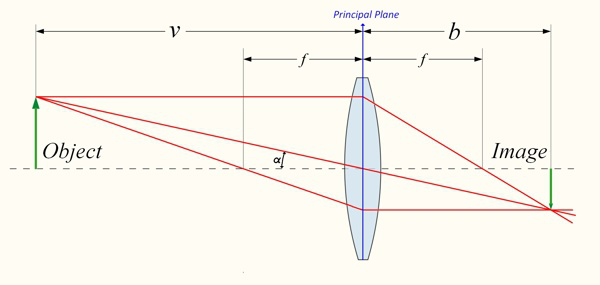

In [167]:
Image.open('../ai2-vision-textbook-dataset/diagrams/turk_data/optics_ray_diagrams_9170.png')

In [144]:
transcription_results_lax = find_transcriptions_matches(recog_res_df, most_common_lax)

In [97]:
# noncon_entries = [entries.values.tolist() for entries in noncon]
# flattened_noncon = [item for sublist in noncon_entries for item in sublist]

In [145]:
# strings_denoting_missing_image = list(pd.Series(flattened_noncon).value_counts()[:20].index)
curated_no_image_strings = set(['*no image showing*', '', ' ', 'NA', '?', 'na', '0', 'No image found', 'blank', 'Nothing showing', "where is the images , i can't see anything", 'NO IMAGE', ''])

In [146]:
non_blank_no_consensus = {d_name: rec_res for d_name, rec_res in noncon.items() if not curated_no_image_strings.intersection(set(rec_res))}
blank_no_consensus = {d_name: rec_res for d_name, rec_res in noncon.items() if curated_no_image_strings.intersection(set(rec_res))}

In [147]:
len(non_blank_no_consensus)

408

In [131]:
len(blank_no_consensus)

99

In [148]:
flattened_noncon_no_blank = [item for sublist in non_blank_no_consensus.values() for item in sublist]
# pd.Series(flattened_noncon_no_blank).value_counts()

In [135]:
flattened_noncon_no_blank = [item for sublist in blank_no_consensus.values() for item in sublist]
pd.Series(flattened_noncon_no_blank).value_counts()

*no image showing*                                       456
                                                         365
                                                         196
NA                                                        73
?                                                         62
na                                                        37
0                                                         21
c                                                         20
blank                                                     19
No image found                                            19
Nothing showing                                           13
where is the images , i can't see anything                11
NO IMAGE                                                   8
Nucleolus                                                  5
Nucleus                                                    5
Nothing                                                    5
Ribosomes               

In [149]:
transcription_results_lax.head(1)

,diagram,box_diag_idx,consensus_res,rectangle,assignment_id
0,acid_rain_formation_6500.png,0,hno3,"[[688, 33], [733, 54]]",3OE22WJIGJO58MJBIMX82UWEGD9QUE


In [150]:
build_diagram_rec_corpus  = [words.split() for words in transcription_results_lax['consensus_res'].values.tolist()]
diagram_rec_corpus = set([item.lower().strip() for sublist in build_diagram_rec_corpus for item in sublist if item.isalpha() and len(item) > 3])

In [152]:
len(diagram_rec_corpus)

4073

# load diagram questions and descriptions

In [9]:
raw_data_dir = '../spare5_produced_data/data/'
rel_file_1 = 'ai2_testquestions_20161004.csv'
rel_file_2 = 'ai2_testquestions_20161005.csv'
decription_rel = 'ai2_diagramdescriptions_20161018.csv'
our_decription_rel = 'our_description.csv'
replacemnt_questions_for_missing_acs = 'ai2_testquestions_20161101.csv'

q_col = '03_write_question'
r_ans_col = '04_write_right_answer'
w_ans_col = '05_write_wrong_answers'
data_cols = [q_col, r_ans_col, w_ans_col]

In [44]:
# rel1_df = pd.read_csv(raw_data_dir + rel_file_1, encoding='latin-1')
rel2_df = pd.read_csv(raw_data_dir + rel_file_2, encoding='latin-1')
replacement_qs = pd.read_csv(raw_data_dir + replacemnt_questions_for_missing_acs, encoding='latin-1')

In [17]:
desc_df = pd.read_csv(raw_data_dir + decription_rel, encoding='latin-1')
desc_df['diagram'] = desc_df['reference_id'].apply(lambda x: x.split('/')[-1])

In [3]:
# %%capture
# our_desc_df = pd.read_csv('../spare5_produced_data/' + our_decription_rel, encoding='latin-1')
# ai2_written_df_completed = our_desc_df[['Topic', 'Image Path', 'Description']]
# ai2_written_df_completed['diagram'] = ai2_written_df_completed['Image Path'].apply(lambda x: x.split('/')[-1])
# ai2_written_df_completed['topic'] = ai2_written_df_completed['Topic']
# del  ai2_written_df_completed['Topic']

In [41]:
replacement_qs

,reference_id,job_batch_id,job_id,user_id,job_user_created_at,finished_at,03_write_question,04_write_right_answer,05_write_wrong_answers
0,https://images.spare5.com/ai2/atomic_mass_numb...,901,8172069,77751,10/3/16 21:31,10/3/16 21:31,what is the atomic mass of Al?,27,"[""13"",""33"",""30""]"
1,https://images.spare5.com/ai2/earth_poles/imag...,901,8172408,65168,10/3/16 22:15,10/3/16 22:15,At what longitude does the Tropic of Cancer lie?,23.5 degrees,"[""66.5 degrees"",""30 degrees"",""0 degrees""]"
2,https://images.spare5.com/ai2/parts_neuron/ima...,901,8173383,77751,10/4/16 13:50,10/4/16 13:50,what is not part of a neuron,fingers,"[""dentrites"",""soma"",""axon""]"
3,https://images.spare5.com/ai2/simple_machines/...,906,8175632,77751,10/4/16 17:33,10/4/16 17:33,which is a more complex pulley system?,d,"[""a"",""c"",""B""]"
4,https://images.spare5.com/ai2/soil_horizons/im...,906,8175663,77751,10/4/16 17:38,10/5/16 3:46,what leter lables the transition?,e,"[""o"",""a"",""B""]"
5,https://images.spare5.com/ai2/acid_rain_format...,908,8175933,71750,10/4/16 1:21,10/4/16 20:47,What harmful emissions from burned fossil fuel...,nitrogen and sulfur oxides,"[""nitrogen and sulfur"",""fog and mist"",""Dry Fal..."
6,https://images.spare5.com/ai2/cycle_rock/image...,908,8176129,77751,10/4/16 21:25,10/4/16 21:25,what is between weathering and deposition?,erosion,"[""extrusion"",""intrusive crystallisation"",""Upli..."
7,https://images.spare5.com/ai2/earth_parts/imag...,908,8176276,75792,10/4/16 21:45,10/4/16 21:45,Which layer of the earth is above the outer co...,Mantle,"[""Inner core"",""Crust"",""outer core""]"
8,https://images.spare5.com/ai2/food_chains_webs...,908,8176378,77751,10/4/16 21:59,10/4/16 21:59,what is the earthworms eaten by?,birds,"[""nematodes"",""arthropods"",""Fungi""]"
9,https://images.spare5.com/ai2/food_chains_webs...,908,8176390,73719,10/4/16 22:02,10/4/16 22:02,On what does the mouse feeds?,Plant,"[""Bird"",""Snake"",""Caterpillar""]"


In [47]:
replacement_qs_proc

0                                                [13, 33, 30]
1                       [66.5 degrees, 30 degrees, 0 degrees]
2                                     [dentrites, soma, axon]
3                                                   [a, c, B]
4                                                   [o, a, B]
5            [nitrogen and sulfur, fog and mist, Dry Fallout]
6              [extrusion, intrusive crystallisation, Uplift]
7                             [Inner core, Crust, outer core]
8                              [nematodes, arthropods, Fungi]
9                                  [Bird, Snake, Caterpillar]
10                                                  [1, 3, 2]
11                                                  [1, 2, 8]
12                                                  [1, 8, 5]
13                                                  [1, 2, 3]
14                                                  [w, x, y]
15                                                  [o, e, C]
16      

In [50]:
dr_proc_df = rel2_df.copy()

dr_proc_df['wac_list'] = dr_proc_df[w_ans_col].apply(lambda x: json.loads(x))
dr_proc_df['topic'] = dr_proc_df['reference_id'].apply(lambda x: x.split('/')[-1].rsplit('_', maxsplit=1)[0])
# dr_proc_df['wac_list'].apply(lambda x: len(x)).value_counts()
replacement_qs_proc = replacement_qs.copy()
replacement_qs_proc['wac_list'] = replacement_qs_proc[w_ans_col].apply(lambda x: json.loads(x))
replacement_qs_proc['topic'] = replacement_qs_proc['reference_id'].apply(lambda x: x.split('/')[-1].rsplit('_', maxsplit=1)[0])
# replacement_qs_proc['wac_list'].apply(lambda x: len(x)).value_counts()

In [12]:
# diagrams_spare5_wrote = set(desc_df['diagram'].values.tolist())
# diagrams_we_wrote = set(ai2_written_df_completed['diagram'].values.tolist())

# diagrams_written_for = diagrams_spare5_wrote.union(diagrams_we_wrote)

# len(diagrams_written_for)

In [65]:
only_complete = dr_proc_df[dr_proc_df.apply(lambda x: x[7] not in x[9], axis=1)]

In [67]:
replacement_qs_proc

,reference_id,job_batch_id,job_id,user_id,job_user_created_at,finished_at,03_write_question,04_write_right_answer,05_write_wrong_answers,wac_list,topic
0,https://images.spare5.com/ai2/atomic_mass_numb...,901,8172069,77751,10/3/16 21:31,10/3/16 21:31,what is the atomic mass of Al?,27,"[""13"",""33"",""30""]","[13, 33, 30]",atomic_mass_number
1,https://images.spare5.com/ai2/earth_poles/imag...,901,8172408,65168,10/3/16 22:15,10/3/16 22:15,At what longitude does the Tropic of Cancer lie?,23.5 degrees,"[""66.5 degrees"",""30 degrees"",""0 degrees""]","[66.5 degrees, 30 degrees, 0 degrees]",earth_poles
2,https://images.spare5.com/ai2/parts_neuron/ima...,901,8173383,77751,10/4/16 13:50,10/4/16 13:50,what is not part of a neuron,fingers,"[""dentrites"",""soma"",""axon""]","[dentrites, soma, axon]",parts_neuron
3,https://images.spare5.com/ai2/simple_machines/...,906,8175632,77751,10/4/16 17:33,10/4/16 17:33,which is a more complex pulley system?,d,"[""a"",""c"",""B""]","[a, c, B]",simple_machines
4,https://images.spare5.com/ai2/soil_horizons/im...,906,8175663,77751,10/4/16 17:38,10/5/16 3:46,what leter lables the transition?,e,"[""o"",""a"",""B""]","[o, a, B]",soil_horizons
5,https://images.spare5.com/ai2/acid_rain_format...,908,8175933,71750,10/4/16 1:21,10/4/16 20:47,What harmful emissions from burned fossil fuel...,nitrogen and sulfur oxides,"[""nitrogen and sulfur"",""fog and mist"",""Dry Fal...","[nitrogen and sulfur, fog and mist, Dry Fallout]",acid_rain_formation
6,https://images.spare5.com/ai2/cycle_rock/image...,908,8176129,77751,10/4/16 21:25,10/4/16 21:25,what is between weathering and deposition?,erosion,"[""extrusion"",""intrusive crystallisation"",""Upli...","[extrusion, intrusive crystallisation, Uplift]",cycle_rock
7,https://images.spare5.com/ai2/earth_parts/imag...,908,8176276,75792,10/4/16 21:45,10/4/16 21:45,Which layer of the earth is above the outer co...,Mantle,"[""Inner core"",""Crust"",""outer core""]","[Inner core, Crust, outer core]",earth_parts
8,https://images.spare5.com/ai2/food_chains_webs...,908,8176378,77751,10/4/16 21:59,10/4/16 21:59,what is the earthworms eaten by?,birds,"[""nematodes"",""arthropods"",""Fungi""]","[nematodes, arthropods, Fungi]",food_chains_webs
9,https://images.spare5.com/ai2/food_chains_webs...,908,8176390,73719,10/4/16 22:02,10/4/16 22:02,On what does the mouse feeds?,Plant,"[""Bird"",""Snake"",""Caterpillar""]","[Bird, Snake, Caterpillar]",food_chains_webs


In [66]:
only_complete

,reference_id,job_batch_id,job_id,user_id,job_user_created_at,finished_at,03_write_question,04_write_right_answer,05_write_wrong_answers,wac_list,topic
0,https://images.spare5.com/ai2-2/aquifers/image...,901,8270800,62690,10/5/16 19:34,10/5/16 19:34,By what letter is the ASR borehole represented...,P,"[""U"",""T"",""R""]","[U, T, R]",aquifers
1,https://images.spare5.com/ai2-2/aquifers/image...,901,8270800,56457,10/5/16 19:17,10/5/16 19:34,Which Letter represents the injection bubble?,W,"[""R"",""F"",""A""]","[R, F, A]",aquifers
2,https://images.spare5.com/ai2-2/aquifers/image...,901,8270801,80045,10/5/16 20:20,10/5/16 20:20,Identify M,Well contaminated with sea water,"[""Major irrigation well"",""Normal water table"",...","[Major irrigation well, Normal water table, Lo...",aquifers
3,https://images.spare5.com/ai2-2/aquifers/image...,901,8270801,77101,10/5/16 18:16,10/5/16 20:20,Which letter represents the Normal interface?,K,"[""R"",""Y"",""F""]","[R, Y, F]",aquifers
4,https://images.spare5.com/ai2-2/aquifers/image...,906,8271529,40386,10/5/16 22:33,NaN,Which label represents a well contaminated wit...,M,"[""X"",""H"",""J""]","[X, H, J]",aquifers
5,https://images.spare5.com/ai2-2/aquifers/image...,901,8270802,80161,10/5/16 18:55,10/5/16 19:12,What is represented by label N?,Saturation level,"[""Pervious Strata"",""Impervious Strata"",""Artesi...","[Pervious Strata, Impervious Strata, Artesian ...",aquifers
6,https://images.spare5.com/ai2-2/aquifers/image...,901,8270802,55568,10/5/16 19:12,10/5/16 19:12,Which label shows the Artesian Well?,D,"[""N"",""L"",""K""]","[N, L, K]",aquifers
7,https://images.spare5.com/ai2-2/aquifers/image...,908,8272260,78711,10/5/16 21:37,10/5/16 21:37,The top of an artesian well is located below w...,N,"[""L"",""K"",""D""]","[L, K, D]",aquifers
8,https://images.spare5.com/ai2-2/aquifers/image...,908,8272260,73555,10/5/16 19:31,10/5/16 21:37,Which label represents water?,L,"[""K"",""N"",""D""]","[K, N, D]",aquifers
9,https://images.spare5.com/ai2-2/aquifers/image...,901,8270803,77101,10/5/16 17:22,10/5/16 18:13,What is the part of the diagram represented wi...,Flowing Artesian Well,"[""Water table well"",""Confined aquifer "",""Uncon...","[Water table well, Confined aquifer , Unconfin...",aquifers


In [71]:
only_complete.columns

Index(['reference_id', 'job_batch_id', 'job_id', 'user_id',
       'job_user_created_at', 'finished_at', '03_write_question',
       '04_write_right_answer', '05_write_wrong_answers', 'wac_list', 'topic'],
      dtype='object')

In [72]:
replacement_qs_proc.columns

Index(['reference_id', 'job_batch_id', 'job_id', 'user_id',
       'job_user_created_at', 'finished_at', '03_write_question',
       '04_write_right_answer', '05_write_wrong_answers', 'wac_list', 'topic'],
      dtype='object')

In [75]:
corrected_process_df = only_complete.append(replacement_qs_proc)
corrected_process_df.shape

(12574, 11)

In [76]:
corrected_process_df

,reference_id,job_batch_id,job_id,user_id,job_user_created_at,finished_at,03_write_question,04_write_right_answer,05_write_wrong_answers,wac_list,topic
0,https://images.spare5.com/ai2-2/aquifers/image...,901,8270800,62690,10/5/16 19:34,10/5/16 19:34,By what letter is the ASR borehole represented...,P,"[""U"",""T"",""R""]","[U, T, R]",aquifers
1,https://images.spare5.com/ai2-2/aquifers/image...,901,8270800,56457,10/5/16 19:17,10/5/16 19:34,Which Letter represents the injection bubble?,W,"[""R"",""F"",""A""]","[R, F, A]",aquifers
2,https://images.spare5.com/ai2-2/aquifers/image...,901,8270801,80045,10/5/16 20:20,10/5/16 20:20,Identify M,Well contaminated with sea water,"[""Major irrigation well"",""Normal water table"",...","[Major irrigation well, Normal water table, Lo...",aquifers
3,https://images.spare5.com/ai2-2/aquifers/image...,901,8270801,77101,10/5/16 18:16,10/5/16 20:20,Which letter represents the Normal interface?,K,"[""R"",""Y"",""F""]","[R, Y, F]",aquifers
4,https://images.spare5.com/ai2-2/aquifers/image...,906,8271529,40386,10/5/16 22:33,NaN,Which label represents a well contaminated wit...,M,"[""X"",""H"",""J""]","[X, H, J]",aquifers
5,https://images.spare5.com/ai2-2/aquifers/image...,901,8270802,80161,10/5/16 18:55,10/5/16 19:12,What is represented by label N?,Saturation level,"[""Pervious Strata"",""Impervious Strata"",""Artesi...","[Pervious Strata, Impervious Strata, Artesian ...",aquifers
6,https://images.spare5.com/ai2-2/aquifers/image...,901,8270802,55568,10/5/16 19:12,10/5/16 19:12,Which label shows the Artesian Well?,D,"[""N"",""L"",""K""]","[N, L, K]",aquifers
7,https://images.spare5.com/ai2-2/aquifers/image...,908,8272260,78711,10/5/16 21:37,10/5/16 21:37,The top of an artesian well is located below w...,N,"[""L"",""K"",""D""]","[L, K, D]",aquifers
8,https://images.spare5.com/ai2-2/aquifers/image...,908,8272260,73555,10/5/16 19:31,10/5/16 21:37,Which label represents water?,L,"[""K"",""N"",""D""]","[K, N, D]",aquifers
9,https://images.spare5.com/ai2-2/aquifers/image...,901,8270803,77101,10/5/16 17:22,10/5/16 18:13,What is the part of the diagram represented wi...,Flowing Artesian Well,"[""Water table well"",""Confined aquifer "",""Uncon...","[Water table well, Confined aquifer , Unconfin...",aquifers


In [78]:
corrected_process_df[corrected_process_df.apply(lambda x: x[7] in x[9], axis=1)]['topic'].value_counts().sum()

0

In [80]:
corrected_process_df.to_pickle('complete_s5_dq.pkl')

In [79]:
dr_proc_df[dr_proc_df.apply(lambda x: x[7] in x[9], axis=1)]

,reference_id,job_batch_id,job_id,user_id,job_user_created_at,finished_at,03_write_question,04_write_right_answer,05_write_wrong_answers,wac_list,topic
25,https://images.spare5.com/ai2-2/blastocyst/ima...,901,8270810,54944,10/5/16 18:13,10/5/16 18:13,Can you identify the blastocyst cavity?,E,"[""P"",""M"",""E""]","[P, M, E]",blastocyst
43,https://images.spare5.com/ai2-2/cycle_carbon/i...,901,8270817,77751,10/5/16 20:15,10/5/16 20:15,identify photosynthesis,r,"[""r"",""e"",""x""]","[r, e, x]",cycle_carbon
54,https://images.spare5.com/ai2-2/cycle_nitrogen...,906,8271549,77751,10/5/16 17:52,10/5/16 19:30,identify condensation,k,"[""m"",""d"",""k""]","[m, d, k]",cycle_nitrogen
62,https://images.spare5.com/ai2-2/cycle_water/im...,901,8270826,77751,10/5/16 18:18,10/5/16 19:59,identify runoff,s,"[""f"",""v"",""s""]","[f, v, s]",cycle_water
74,https://images.spare5.com/ai2-2/cycle_water/im...,901,8270830,77751,10/5/16 18:51,10/5/16 18:51,identify the surface outflow,w,"[""w"",""p"",""v""]","[w, p, v]",cycle_water
77,https://images.spare5.com/ai2-2/cycle_water/im...,901,8270831,77751,10/5/16 18:15,10/5/16 18:24,identify condensation,u,"[""u"",""k"",""e""]","[u, k, e]",cycle_water
90,https://images.spare5.com/ai2-2/earth_day_nigh...,908,8272291,77751,10/5/16 17:44,NaN,identify south,d,"[""r"",""l"",""d""]","[r, l, d]",earth_day_night
198,https://images.spare5.com/ai2-2/earth_parts/im...,901,8270871,77751,10/5/16 20:17,10/5/16 20:17,identify the mantle,t,"[""m"",""t"",""r""]","[m, t, r]",earth_parts
266,https://images.spare5.com/ai2-2/earth_parts/im...,908,8272345,77751,10/5/16 22:44,10/5/16 23:37,what protects the earthÍs crust from the core?,mantle,"[""air"",""rock"",""mantle""]","[air, rock, mantle]",earth_parts
267,https://images.spare5.com/ai2-2/earth_parts/im...,901,8270890,77751,10/5/16 20:17,10/5/16 20:17,identify the crust,j,"[""j"",""u"",""l""]","[j, u, l]",earth_parts


In [97]:
# dr_proc_df[dr_proc_df.apply(lambda x: x[7] in x[9], axis=1)]['job_id'].to_csv('q_job_id_missing_ac.csv', index=False)

# Integrate diagrams and text

## match diagram topics to lessons

first need to match diagram topic to flexbook lesson-

In [110]:
with open('../diagram_questions/topic_match_terms.json', 'r') as f:
    topic_term_match = json.load(f)    

In [111]:
working_topic_list = clean_list(pruned_dir)

In [112]:
es_lesson_names = [item for sublist in [val['topics'].keys() for val in ck12_combined_dataset['earth-science'].values()] for item in sublist]
ps_lesson_names = [item for sublist in [val['topics'].keys() for val in ck12_combined_dataset['physical-science'].values()] for item in sublist]
ls_lesson_names = [item for sublist in [val['topics'].keys() for val in ck12_combined_dataset['life-science'].values()] for item in sublist]

combined_lessons = es_lesson_names + ps_lesson_names + ls_lesson_names
topic_series = pd.Series(combined_lessons).value_counts()
topics_to_remove = list(topic_series[:17].index)

In [113]:
combined_topics = defaultdict(dict)
for subject, book in ck12_combined_dataset.items():
    for lesson, material in book.items():
        for topic, text in material['topics'].items():
            if topic in topics_to_remove:
                continue
#             combined_topics[topic.lower()]['text'] = text['content']['text']
            combined_topics[topic.lower()]['lesson'] = lesson

In [114]:
import fuzzywuzzy.fuzz as fuzz
def make_topic_matches(topic_list, combined_topics):
    topic_matches = {}
    for diagram_topic in topic_list:
        topic_matches[diagram_topic] = []
        for terms in topic_term_match[diagram_topic]:
            lev_dist_threshed = [topic for topic in combined_topics.keys() if fuzz.ratio(topic, terms) > 85]
            topic_matches[diagram_topic] += lev_dist_threshed
        if not topic_matches[diagram_topic]:
                for terms in topic_term_match[diagram_topic]:
                    lev_dist_threshed = [topic for topic in combined_topics.keys() if fuzz.token_set_ratio(topic, terms) > 80]
                    topic_matches[diagram_topic] += lev_dist_threshed
    return topic_matches

In [115]:
def make_lesson_matches(ck12_dataset, diagram_topic_name, topic_matches):
    lesson_matches = defaultdict(list)
    lessons_seen = set()
    content_topics =  topic_matches[diagram_topic_name]
    for topic in sorted(content_topics):
        associated_lesson =combined_topics[topic]['lesson']
        if associated_lesson not in lessons_seen:
            lessons_seen.add(associated_lesson)
            lesson_matches[diagram_topic_name].append(associated_lesson)
    return dict(lesson_matches)

In [116]:
topic_matches = make_topic_matches(working_topic_list, combined_topics)
missing= []
for k, v in topic_matches.items():
    if not v:
        missing.append(k)

In [117]:
matching_lessons = {}
for topic in working_topic_list:
    matched_lessons = make_lesson_matches(ck12_combined_dataset, topic, topic_matches)
    matching_lessons.update(matched_lessons)

In [118]:
diagram_lesson_lookup = {}
for d_topic, lessons in matching_lessons.items():
#     try:
#         diagram_lesson_lookup[d_topic] = sorted(lessons, key= lambda x: int(x.split('.')[0]))[0]
#     except ValueError:
    diagram_lesson_lookup[d_topic] = sorted(lessons)[0]

In [119]:
len(diagram_lesson_lookup.keys())

102

In [120]:
len(set(diagram_lesson_lookup.values()))

84

In [126]:
for k, v in sorted(matching_lessons.items()):
    print(k)
    print(sorted(v))
    print()

acid_rain_formation
['22.2 Effects of Air Pollution']

aquifers
['13.3 Groundwater']

atomic_mass_number
['3.1 Properties of Matter', '5.1 Inside the Atom', 'atomic number']

atomic_structure
['5.1 Inside the Atom']

biomes
['climate zones and biomes']

blastocyst
['22.3 Reproduction and Life Stages']

cell_division
['5.1 Cell Division']

cellular_respiration
['9.4 Biochemical Reactions']

chemical_bonding_covalent
['7.3 Covalent Bonds']

chemical_bonding_ionic
['7.2 Ionic Bonds']

circuits
['23.3 Electric Circuits']

continental_drift
['6.2 Continental Drift']

convection_of_air
['18.2 Transfer of Thermal Energy']

cycle_carbon
['18.2 Cycles of Matter']

cycle_nitrogen
['18.2 Cycles of Matter']

cycle_rock
['4.1 Types of Rocks', 'rocks and processes of the rock cycle']

cycle_water
['24.2 Cycles of Matter']

dna
['nucleic acid classification']

earth_day_night
['rotation of earth']

earth_eclipses
['eclipses']

earth_magnetic_field
['24.2 Earth as a Magnet']

earth_moon_phases
['24.4 

In [127]:
lessons_seen = []
dupe_lessons = []
for k, v in diagram_lesson_lookup.items():
    if v not in lessons_seen:
        lessons_seen.append(v)
    else:
        dupe_lessons.append(v)

In [128]:
dupe_topics = defaultdict(list)
for k, v in diagram_lesson_lookup.items():
    if v in dupe_lessons:
        dupe_topics[v].append(k)

In [129]:
pprint.pprint(dict(dupe_topics))

{'10.1 Introduction to Plants': ['parts_plant', 'types_leaves', 'parts_leaf'],
 '10.2 Evolution and Classification of Plants': ['parts_flower', 'parts_seed'],
 '14.2 Ocean Movements': ['tides', 'ocean_waves'],
 '16.2 The Integumentary System': ['hair_follicles', 'skin_cross_section'],
 '16.4 The Muscular System': ['human_system_muscular', 'muscle_fiber'],
 '18.2 Cycles of Matter': ['cycle_carbon', 'cycle_nitrogen'],
 '20.1 The Nervous System': ['human_system_nervous', 'parts_neuron'],
 '22.2 Optics': ['optics_refraction', 'parts_telescope', 'optics_lense_types'],
 '4.3 Changes of State': ['evaporation_and_sublimation', 'state_change'],
 '5.1 Cell Division': ['cell_division', 'eukaryotic_cell_cycles'],
 '5.1 Inside the Atom': ['atomic_structure', 'isotopes'],
 '6.4 Theory of Plate Tectonics': ['tectonic_plates_motion', 'tectonic_plates'],
 'law of reflection': ['optics_reflection', 'optics_rays']}


In [161]:
diagram_lesson_lookup['lewis_dot_diagrams'] = diagram_lesson_lookup['lewis_dots']
diagram_lesson_lookup['optics_ray_diagrams'] = diagram_lesson_lookup['optics_rays']

In [74]:
# list(ck12_combined_dataset['earth-science'].values())[0]['questions']

## merge questions

In [4]:
dr_proc_df[dr_proc_df['topic'].isin(['parts_plant', 'types_leaves', 'parts_leaf'])].shape

NameError: name 'dr_proc_df' is not defined

In [154]:
dq_image_folder = 'diagram-question-images/'
td_image_folder = 'diagram-teaching-images/'

In [155]:
dr_proc_df['reference_id'][0]

'https://images.spare5.com/ai2-2/aquifers/images/aquifers_16517.png'

In [156]:
s3_base = 'https://s3.amazonaws.com/ai2-vision-textbook-dataset/diagrams/' + dq_image_folder
s3_base_descriptions = 'https://s3.amazonaws.com/ai2-vision-textbook-dataset/diagrams/' + td_image_folder

def make_image_link(old_url, s3_base=s3_base):
    image_name = old_url.split('/')[-1]
    new_url = s3_base + image_name
    return new_url

In [162]:
dr_proc_df['diagram'] = dr_proc_df['reference_id'].apply(lambda x: x.split('/')[-1])
dr_proc_df['s3_uri'] = dr_proc_df['reference_id'].apply(make_image_link)
dr_proc_df['lesson_assigned_to'] = dr_proc_df['topic'].apply(lambda x: diagram_lesson_lookup[x])

In [107]:
import random
def make_question_entry(qdf_row):
    ask = qdf_row[qdf_row.index == '03_write_question'].values[0]
    answer = qdf_row[qdf_row.index == '04_write_right_answer'].values[0]
    wrong_answers = qdf_row[qdf_row.index == 'wac_list'].values[0]
    q_topic = qdf_row[qdf_row.index == 'lesson_assigned_to'].values[0]
    image_uri = qdf_row[qdf_row.index == 's3_uri'].values[0]
    image_name = qdf_row[qdf_row.index == 'diagram'].values[0]
    
    def make_answer_choices(answer_choices):
        build_answer_choices = {}
        letter_options = list('abcd')
        random.shuffle(answer_choices)
        for idx, answer_choice in enumerate(answer_choices):
            answer_choice_dict = {
                "idStructural": letter_options[idx] + '.',
                "rawText": answer_choice,
                "processedText": answer_choice
            }
            build_answer_choices[letter_options[idx]] = answer_choice_dict
        return build_answer_choices
    a_choices = make_answer_choices(wrong_answers + [answer])
    single_q_dict = {
        "id": 'q',
        "type": 
            "Diagram Multiple Choice",
        "beingAsked": {
            "rawText": ask,
            "processedText": ask.encode('ascii', 'ignore').decode('utf-8')
        },
        "correctAnswer": {
            "rawText": answer,
            "processedText": answer.encode('ascii', 'ignore').decode('utf-8')
        },
        "answerChoices": a_choices,
        "imageUri": image_uri,
        "imageName": image_name
    }
    build_questions[q_topic].append(single_q_dict)
    
    
def refine_question_formats(raw_questions):
    reformatted_dq_ds = {}
    for topic, topic_questions in raw_questions.items():
        reformatted_topic = {topic: {'questions': {'diagramQuestions': {}}}}
        reformatted_questions = {}
        for idx, question in enumerate(topic_questions):
            question = deepcopy(question)
            question['id'] += str(idx + 1).zfill(4)
            reformatted_questions[question['id']] = question
        reformatted_topic[topic]['questions']['diagramQuestions'] = reformatted_questions
        reformatted_dq_ds.update(reformatted_topic)
    return reformatted_dq_ds

In [163]:
build_questions = defaultdict(list)

In [164]:
_ = dr_proc_df.apply(make_question_entry, axis=1)

In [165]:
refined_questions = dict(refine_question_formats(build_questions))

In [167]:
refined_questions['10.4 Erosion and Deposition by Glaciers']['questions'].keys()

dict_keys(['diagramQuestions'])

In [169]:
# with open(output_dir + 'ck12_dataset_beta_v3_5.json', 'r') as f:
#     ck12_combined_dataset = json.load(f)

In [170]:
for subject, lessons in ck12_combined_dataset.items():
    for l_name, lesson in lessons.items():
        if l_name in refined_questions.keys():        
            lesson['questions']['diagramQuestions'] = refined_questions[l_name]['questions']['diagramQuestions']

In [171]:
refined_questions['10.4 Erosion and Deposition by Glaciers']

{'questions': {'diagramQuestions': {'q0001': {'answerChoices': {'a': {'idStructural': 'a.',
      'processedText': 'Snout',
      'rawText': 'Snout'},
     'b': {'idStructural': 'b.',
      'processedText': 'Zone of ablation',
      'rawText': 'Zone of ablation'},
     'c': {'idStructural': 'c.',
      'processedText': 'Moraine',
      'rawText': 'Moraine'},
     'd': {'idStructural': 'd.',
      'processedText': 'Zone of accumulation',
      'rawText': 'Zone of accumulation'}},
    'beingAsked': {'processedText': 'Which structure marks the greatest distance the glacier advanced?',
     'rawText': 'Which structure marks the greatest distance the glacier advanced?'},
    'correctAnswer': {'processedText': 'Moraine', 'rawText': 'Moraine'},
    'id': 'q0001',
    'imageName': 'glaciers_6927.png',
    'imageUri': 'https://s3.amazonaws.com/ai2-vision-textbook-dataset/diagrams/diagram-question-images/glaciers_6927.png',
    'type': 'Diagram Multiple Choice'},
   'q0002': {'answerChoices': {'

In [172]:
len(ck12_combined_dataset['earth-science']['10.4 Erosion and Deposition by Glaciers']['questions']['diagramQuestions'])

33

In [173]:
len(ck12_combined_dataset['earth-science']['10.4 Erosion and Deposition by Glaciers']['questions']['nonDiagramQuestions'])

31

In [174]:
val_counts=dr_proc_df['lesson_assigned_to'].value_counts()

## merge descriptions

In [177]:
def make_description_entry(qdf_row):
    description = qdf_row[qdf_row.index == 'Description'].values[0]
    q_topic = qdf_row[qdf_row.index == 'lesson_assigned_to'].values[0]
    image_uri = qdf_row[qdf_row.index == 's3_uri'].values[0]
    image_name = qdf_row[qdf_row.index == 'diagram'].values[0]

    single_desc_dict = {
        
        "imageUri": image_uri,
        "imageName": image_name,
        "rawText": description,
        "processedText": description.encode('ascii', 'ignore').decode('utf-8')
    }
    build_descriptions[q_topic].update({image_name.replace('.png', ''): single_desc_dict})

In [178]:
%%capture
ai2_written_df_completed['topic'] = ai2_written_df_completed['diagram'].apply(lambda x: x.rsplit('_', maxsplit=1)[0])
ai2_written_df_completed['lesson_assigned_to'] = ai2_written_df_completed['topic'].apply(lambda x: diagram_lesson_lookup[x])
ai2_written_df_completed['s3_uri'] = ai2_written_df_completed['Image Path'].apply(make_image_link)
ai2_written_df_completed = ai2_written_df_completed.dropna()

In [179]:
ai2_written_df_completed.shape

(83, 7)

In [180]:
%%capture
desc_df['topic'] = desc_df['diagram'].apply(lambda x: x.rsplit('_', maxsplit=1)[0])
desc_df['lesson_assigned_to'] = desc_df['topic'].apply(lambda x: diagram_lesson_lookup[x])
desc_df['s3_uri'] = desc_df['reference_id'].apply(make_image_link)
desc_df['Description'] = desc_df['01_write_description']             

In [181]:
build_descriptions = defaultdict(dict)

In [182]:
_ = desc_df.apply(make_description_entry, axis=1)
_ = ai2_written_df_completed.apply(make_description_entry, axis=1)

In [183]:
build_descriptions.keys()

dict_keys(['5.1 Cell Division', '14.1 Introduction to the Oceans', '18.2 Cycles of Matter', '20.1 The Nervous System', 'nucleic acid classification', '9.2 Soils', '17.1 Climate and Its Causes', '12.5 Echinoderms and Invertebrate Chordates', '24.2 Cycles of Matter', 'radioactive decay as a measure of age', '8.3 Types of Volcanoes', '19.2 The Excretory System', '1.4 The Microscope', '16.3 The Skeletal System', '9.1 Protists', '14.3 The Ocean Floor', '4.1 Solids Liquids Gases and Plasmas', '6.1 Inside Earth', '10.1 Erosion and Deposition by Flowing Water', 'earth as a magnet', '16.3 Simple Machines', '10.2 Evolution and Classification of Plants', '9.2 Fungi', 'flatworms', '5.1 Inside the Atom', 'rotation of earth', '21.3 First Two Lines of Defense', 'nails and hair', '9.4 Biochemical Reactions', 'clouds', '10.4 Erosion and Deposition by Glaciers', '25.1 Introduction to the Solar System', 'blood vessels', '25.2 Using Electromagnetism', '19.1 The Respiratory System', 'faults', '13.2 Fish', 

In [184]:
pd.unique(desc_df['lesson_assigned_to']).shape

(83,)

In [451]:
for subject, lessons in ck12_combined_dataset.items():
    for l_name, lesson in lessons.items():
        if l_name in refined_descriptions.keys():
            lesson['instructionalDiagrams'] = build_descriptions[l_name]
        else:
            lesson['instructionalDiagrams'] = {}

In [185]:
# with open(output_dir + 'ck12_dataset_beta_v4.json', 'w') as f:
#     json.dump(ck12_combined_dataset, f, indent=4, sort_keys=True)

In [186]:
# with open(output_dir + 'ck12_dataset_beta_v4.json', 'r') as f:
#     ck12_combined_dataset = json.load(f)

# Apply spelling and grammar fixes

## spelling experiments

In [187]:
import language_check
import enchant

In [188]:
output_dir = 'output_data_from_nbs/'

with open(output_dir + 'ck_12_vocab_words.pkl', 'rb') as f:
    ck_12_vocab = set(pickle.load(f))
    
with open(output_dir + 'ck_12_all_words.pkl', 'rb') as f:
    ck_12_corp = set(pickle.load(f))
    
with open(output_dir + 'spellings_to_rev.txt', 'r') as f:
    whitelisted_words = f.read().split('\n')[:-1]
    
with open(output_dir + './desc_spellings_to_rev.txt', 'r') as f:
    whitelisted_words += f.read().split('\n')[:-1]
  
with open(output_dir + './ck_12_spelling_rev.txt', 'r') as f:
    whitelisted_words += f.read().split('\n')[:-1]


In [189]:
ck_12_corp.update(ck_12_vocab)
ck_12_corp.update(whitelisted_words)
ck_12_corp.update(diagram_rec_corpus)

edict = enchant.Dict("en_US")
anglo_edict = enchant.Dict("en_UK")
cached_sw = stopwords.words("english") + list(string.punctuation)

for word in ck_12_corp:
    if word.isalpha() and len(word) > 3:
        edict.add(word)

In [190]:
combined_desc_df = desc_df.append(ai2_written_df_completed.dropna())
combined_desc_df['desc_len'] = combined_desc_df['Description'].apply(len)
more_than_1_desc = combined_desc_df['diagram'].value_counts()[(combined_desc_df['diagram'].value_counts() > 1)].index.values.tolist()
multiple_desc_by_diagram = combined_desc_df[combined_desc_df['diagram'].isin(more_than_1_desc)].groupby('diagram')
max_len_lookup = list(combined_desc_df.groupby('diagram').agg({'desc_len': max}).to_dict().values())[0]
longer_descs = combined_desc_df[combined_desc_df[['diagram', 'desc_len']].apply(lambda x: x[1] == max_len_lookup[x[0]], axis =1)].drop_duplicates('diagram')

In [192]:
flattened_questions = flattened_dict = {k: v['questions']['diagramQuestions'] for d in ck12_combined_dataset.values() for k, v in d.items() if v['questions']['diagramQuestions']}
flattened_descriptions = flattened_dict = {k: v['instructionalDiagrams'] for d in ck12_combined_dataset.values() for k, v in d.items() if v['instructionalDiagrams']}

KeyError: 'instructionalDiagrams'

In [193]:
ai2_wr = longer_descs['Description'].values.tolist()

In [195]:
# desc_tokens = wordpunct_tokenize(description_corpus)
# normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in desc_tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]
# unique_words = set(normalized_tokens)
# dw_freq_d = nltk.FreqDist(normalized_tokens)
# most_common_dw = dw_freq_d.most_common(10)

In [197]:
# misspelled_words = [word for word in unique_words if check_mispelled(word) and word.isalpha() and len(word) > 3]

In [198]:
# trans_replace = {}
# for word in misspelled_words:
#     suggestions = edict.suggest(word)
#     suggested_replacement = correct_spelling_error(word, suggestions)
#     trans_replace[word] = suggested_replacement

## grammar experiments

In [199]:
import difflib
import diff_match_patch
dmp = diff_match_patch.diff_match_patch()

In [202]:
sp5_wr = desc_df['Description'].values.tolist()
ai2_wr = ai2_written_df_completed['Description'].values.tolist()
all_desc_wr = longer_descs['Description'].values.tolist()

ts1 = longer_descs['Description']
ts1.index = longer_descs['diagram']
diagram_desc_dict = ts1.to_dict()

In [203]:
gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['SENT_START_CONJUNCTIVE_LINKING_ADVERB_COMMA', 'POSSESSIVE_APOSTROPHE', 'A_PLURAL'])
gram_checker.disable_spellchecking()

In [204]:
gram_checker.disabled

{'A_PLURAL',
 'HUNSPELL_NO_SUGGEST_RULE',
 'HUNSPELL_RULE',
 'MORFOLOGIK_RULE_EN_US',
 'POSSESSIVE_APOSTROPHE',
 'SENT_START_CONJUNCTIVE_LINKING_ADVERB_COMMA'}

In [205]:
desc_with_errors = {}
corrected_desc = {}
for diag, desc_text in diagram_desc_dict.items():
    errors = gram_checker.check(desc_text)
    if errors:
        desc_with_errors[diag] = errors
        corrected_desc[diag] = gram_checker.correct(desc_text)

In [208]:
# num_errors = [len([match for match in matches if match.locqualityissuetype != 'grammar']) for matches in grammar_errors_in_dec]
# num_errors =  [len(matches) for matches in desc_with_errors]
# pd.Series(num_errors).value_counts()

In [1874]:
etyps = []
for match in grammar_errors_in_dec:
    if match:
        for mat in match:
            etyps.append(mat.ruleId)
#             etyps.append(match)
            if mat.locqualityissuetype == 'style':
                print(mat.ruleId)
                etyps.append(mat.ruleId)

# pd.Series(etyps).value_counts()

ALL_OF_THE
SOME_OF_THE
SOME_OF_THE
OF_ANY_OF
SOME_OF_THE
SOME_OF_THE
NUMEROUS_DIFFERENT
SOME_OF_THE
NUMEROUS_DIFFERENT
SO_AS_TO
ALL_OF_THE
ALL_OF_THE
SOME_OF_THE
ALL_OF_THE
SOME_OF_THE
LARGE_NUMBER_OF
NUMEROUS_DIFFERENT
ADJECTIVE_IN_ATTRIBUTE
NUMEROUS_DIFFERENT
NUMEROUS_DIFFERENT
NUMEROUS_DIFFERENT
ALL_OF_THE
NUMEROUS_DIFFERENT
ALL_OF_THE
ALL_OF_THE
NUMEROUS_DIFFERENT
SOME_OF_THE
SOME_OF_THE
ADJECTIVE_IN_ATTRIBUTE
SOME_OF_THE


In [209]:
len(corrected_desc)

153

In [212]:
diag_to_ex = random.choice(list(corrected_desc.keys()))
orig_text = diagram_desc_dict[diag_to_ex]
corrected_text = corrected_desc[diag_to_ex]
diff = dmp.diff_main(orig_text, corrected_text)
HTML(dmp.diff_prettyHtml(diff))

In [213]:
questions_asked = dr_proc_df['03_write_question'].values.tolist()

In [214]:
orig_text = []
replaced_text = []
for subject, flexbook in ck12_combined_dataset.items():
    for lesson_name, lesson in flexbook.items():
        if lesson['questions']['diagramQuestions']:
            for qid, question in lesson['questions']['diagramQuestions'].items():
                ot = question['beingAsked']['rawText']
                errors = gram_checker.check(ot)
                if errors:
                    orig_text.append(ot)
                    replaced_text.append(gram_checker.correct(desc_text))
                    

KeyboardInterrupt: 

## Apply to dataset

In [219]:
def check_mispelled(word):
    return word and word.isalpha() and not (edict.check(word) or anglo_edict.check(word) or edict.check(word[0].upper() + word[1:]))

def correct_spelling_error(misspelled_word, suggested_spellings):
    highest_ratio = 0
    closest_match = None
    for word in suggested_spellings:
        match_r = fuzz.ratio(misspelled_word, word)
        if match_r >= highest_ratio and (word[0] == misspelled_word[0] or not check_mispelled(word[0] + misspelled_word)) and len(misspelled_word) <= len(word):
            highest_ratio = match_r
            closest_match = word
            break
    spell_changes[misspelled_word] = closest_match
    return closest_match

def apply_spelling_fix(orig_text):
    orig_text_tokens = wordpunct_tokenize(orig_text)
    processed_tokens = []
    for token in orig_text_tokens:
        norm_token = token.lower()
        if len(norm_token) < 4:
            processed_tokens.append(token)
            continue
        if check_mispelled(norm_token):
            suggested_replacements = edict.suggest(token)
            replacement_text = correct_spelling_error(norm_token, suggested_replacements)
            if replacement_text:
                if norm_token[0].isupper():
                    replacement_text = upper(replacement_text[0]) + replaced_text[1:]
                processed_tokens.append(replacement_text)
            else:
                processed_tokens.append(token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

def diff_corrected_text(orig_text, corrected_text):
    diff = dmp.diff_main(orig_text, corrected_text)
    return HTML(dmp.diff_prettyHtml(diff))

def specify_lesson_q_path(lesson):
    pass
    

def apply_spelling_and_grammar_to_ds(ck12_ds):
    return

In [224]:
with open(output_dir + 'ck12_dataset_beta_v4.json', 'r') as f:
    ck12_combined_dataset = json.load(f)

In [225]:
ck12_spell_gramm_fix_test = deepcopy(ck12_combined_dataset)

In [226]:
gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['SENT_START_CONJUNCTIVE_LINKING_ADVERB_COMMA', 'POSSESSIVE_APOSTROPHE', 'A_PLURAL'])
gram_checker.disable_spellchecking()

punc_set_space = set([',', ':', ';', '/"'])
punc_set_nospace = set(['-', '\'', '-', '?', '.', '!'])
question_enders = set(['.', '?', ':'])

In [227]:
spell_changes = {}
unaltered_text = []
replaced_text = []
for lesson in list(ck12_spell_gramm_fix_test['life-science'].values()):
    if lesson['instructionalDiagrams']:
        for diagram, description in lesson['instructionalDiagrams'].items():
            orig_text = description['processedText']
            spell_fixed_text = apply_spelling_fix(orig_text)
            for punc_char in punc_set_nospace:
                spell_fixed_text = spell_fixed_text.replace(' ' + punc_char + ' ' , punc_char)
            for punc_char in punc_set_space:
                spell_fixed_text = spell_fixed_text.replace(' ' + punc_char + ' ' , punc_char + ' ')
            gram_fixed = gram_checker.correct(spell_fixed_text)
            if gram_fixed != orig_text:
                unaltered_text.append(orig_text)
                replaced_text.append(gram_fixed)

In [2603]:
spell_changes = {}
unaltered_text = []
replaced_text = []
for lesson in list(ck12_spell_gramm_fix_test['life-science'].values()):
    if lesson['questions']['nonDiagramQuestions']:
        for diagram, description in lesson['questions']['nonDiagramQuestions'].items():
            orig_text = description['beingAsked']['processedText']
            spell_fixed_text = apply_spelling_fix(orig_text)
            gram_fixed = gram_checker.correct(spell_fixed_text)
            for punc_char in punc_set_nospace:
                gram_fixed = gram_fixed.replace(' ' + punc_char + ' ' , punc_char)
                gram_fixed = gram_fixed.replace(' ' + punc_char, punc_char)
            for punc_char in punc_set_space:
                gram_fixed = gram_fixed.replace(' ' + punc_char + ' ' , punc_char + ' ')
            if gram_fixed[-1] not in question_enders:
                if gram_fixed.split()[0] in ['Identify', 'Name'] or '__' in gram_fixed:
                    gram_fixed += '.'
                else:
                    gram_fixed += '?'
            if gram_fixed != orig_text:
                unaltered_text.append(orig_text)
                replaced_text.append(gram_fixed)

In [228]:
comp_text = list(zip(unaltered_text, replaced_text))

In [229]:
len(comp_text)

62

In [230]:
print(len(spell_changes))
spell_changes

18


{'assemly': 'assembly',
 'asteroidea': None,
 'begind': 'behind',
 'cacncal': 'canonical',
 'carbondioxide': 'carbon dioxide',
 'cererbum': None,
 'contols': 'controls',
 'everythign': 'everything',
 'followd': 'followed',
 'gell': 'gall',
 'majorly': 'majority',
 'microcompartments': 'micro compartments',
 'ontrols': 'controls',
 'protezoic': None,
 'resipration': 'respiration',
 'stemlike': 'stem like',
 'subdivded': 'subdivided',
 'timeframes': 'time frames'}

In [244]:
rand_idx = np.random.randint(len(comp_text))
print(rand_idx)
diff_corrected_text(*comp_text[rand_idx])

54


In [245]:
print(unaltered_text[rand_idx])
print()
print(replaced_text[rand_idx])

This diagram depicts the human skeleton. The axial skeleton includes the skull, vertebral column, and thoracic cage. The skull consists of 28 bones: 8 cranial vault bones, 14 facial bones, and 6 auditory ossicles. From a lateral view, the parietal, temporal, and sphenoid bones can be seen. From a frontal view, the orbits and nasal cavity can be seen, as well as associated bones and structures, such as the frontal bone, zygomatic bone, maxilla, and mandible. The interior of the cranial vault contains three fossae with several foramina. Seen from below, the base of the skull reveals numerous foramina and other structures, such as processes for muscle attachment. The vertebral column contains 7 cervical, 12 thoracic, and 5 lumbar vertebrae, plus 1 sacral and 1 coccygeal bone. Each vertebra consists of a body, an arch, and processes. Regional differences in vertebrae are as follows: cervical vertebrae have transverse foramina; thoracic vertebrae have long spinous processes and attachment s

# Refinements

 ## Todo
global ids

make all abc questions upper/lower case

add vocab defs

punctuation/ text normalization

maybe spell and grammar on entire set

linking lessons

In [251]:
from pdfextraction.assemble_dataset import load_ds

In [254]:
ck_12_c = load_ds()

# Experiments

## image number counts

In [239]:
nfbtb = 1490
nwsl = 1811
print(nfbtb + nwsl)

ndq = 2049
ndqabc = 719
ndd = 276
print(ndqabc + ndq + ndd)

nfbtb + nwsl + ndqabc + ndq + ndd

3301
3044


6345

## topic collisions

In [42]:
flexbook_ds.keys()

dict_keys(['physical-science', 'earth-science', 'life-science'])

In [44]:
build_website_lessons = [list(lesson.keys()) for lesson in lessons_ds.values()]
website_lessons= sorted([item for sublist in build_website_lessons for item in sublist])

build_flexbook_lessons = [list(lesson.keys()) for lesson in flexbook_ds.values()]
flexbook_lessons= [item for sublist in build_flexbook_lessons for item in sublist]
flexbook_lessons = sorted([lesson.split(maxsplit=1)[1].strip().lower() for lesson in flexbook_lessons])
fbls = set(flexbook_lessons)
wsls = set(website_lessons)

In [45]:
len(flexbook_lessons)

247

In [46]:
print(len(flexbook_lessons))
print(len(set(flexbook_lessons)))

247
243


In [47]:
print(len(website_lessons))
print(len(set(website_lessons)))

829
829


In [48]:
len(set(website_lessons).union(set(flexbook_lessons)))

1024

# End

In [1081]:
line_split = re.compile(r'[?.]')

from pygments import highlight
from pygments.lexers import diff as difflex
from pygments.formatters import HtmlFormatter

from IPython.core.display import HTML

display(HTML("""
<style>
{pygments_css}
</style>
""".format(pygments_css=HtmlFormatter().get_style_defs('.highlight'))))
display(HTML(data=highlight(, difflex(), HtmlFormatter())))

diff = difflib.context_diff(line_split.split(orig_text), line_split.split(corrected_text))
diff

import pygments

pygments.

pygments.pygmentize -f html -O full,style=trac -l diff -o last.diff.html last.diff

diff.make_file(fromline

d = difflib.Differ()
diff = d.compare(line_split.split(orig_text), line_split.split(corrected_text))
print('\n'.join(diff))

In [1827]:
tt = 'cacncal'
suggested_replacements = edict.suggest(tt)
correct_spelling_error(tt, suggested_replacements)

orig_text = []
replaced_text = []
for subject, flexbook in ck12_combined_dataset.items():
    for lesson_name, lesson in flexbook.items():
        if lesson['questions']['diagramQuestions']:
            for qid, question in lesson['questions']['diagramQuestions'].items():
                ot = question['beingAsked']['rawText']
                errors = gram_checker.check(ot)
                if errors:
                    orig_text.append(ot)
                    replaced_text.append(gram_checker.correct(desc_text))

'cancel'

In [ ]:
for subject, flexbook in ck12_combined_dataset_cleaned.items():
    validator = jsonschema.Draft4Validator(schema)
    for error in sorted(validator.iter_errors(flexbook), key=lambda x: x.absolute_path[0]):
        print(error.message)
        print(list(error.absolute_path)[:4])
        print('\n' * 2)

In [723]:
build_spelling_lookup = defaultdict(list)
for word in ck_12_corp:
    start_letter = word[0]
    if start_letter in string.ascii_letters:
        build_spelling_lookup[start_letter].append(word)

In [724]:
spelling_lookup = {starting_letter: sorted(words) for starting_letter, words in build_spelling_lookup.items()}

In [925]:
def try_splitting(tw):
    for idx in range(len(tw)):
        sp1, sp2 = tw[:idx], tw[idx:]
        if not (check_mispelled(sp1) or check_mispelled(sp2)) and len(sp1) > 3 and len(sp2) > 3:
            return sp1, sp2
    return None